# Simple convolutional neural network to perform classification.


The project focuses on developing and comparing image classification models using convolutional neural networks (CNNs). First, we build a custom CNN model from scratch, train it on a chosen dataset, and evaluate its performance. Next, we fine-tune two pre-trained state-of-the-art models, such as ResNet or AlexNet, and compare their performance with our custom model.

The goal of this is to understand the trade-offs between designing a CNN from scratch and using pre-trained models through transfer learning. From this we get a chance to explore key concepts like network architecture, activation functions, optimizers, and overfitting, while analyzing how different models handle image classification tasks.

### 1.Import Libraries

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

### 2.Load and Process Data

In [2]:
# Data Pre-processing

# Paths
dataset_path = r'C:\Users\STZ\Downloads\realwaste-main\RealWaste'
base_dir = r'C:\Users\STZ\Downloads\realwaste-main\Splits'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Ratios for splitting the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Ensure directories are clean
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# Split dataset into train, val, and test folders
classes = os.listdir(dataset_path)
for cls in classes:
    cls_path = os.path.join(dataset_path, cls)
    if not os.path.isdir(cls_path):
        continue

    images = os.listdir(cls_path)
    train_size = int(len(images) * train_ratio)
    val_size = int(len(images) * val_ratio)

    # Shuffle and split
    train_images, temp_images = train_test_split(images, train_size=train_size, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=test_ratio / (test_ratio + val_ratio), random_state=42)

    # Copy images to respective folders
    for img_set, target_dir in [(train_images, train_dir), (val_images, val_dir), (test_images, test_dir)]:
        cls_target_dir = os.path.join(target_dir, cls)
        os.makedirs(cls_target_dir, exist_ok=True)
        for img in img_set:
            shutil.copy(os.path.join(cls_path, img), os.path.join(cls_target_dir, img))

Found 2848 images belonging to 9 classes.
Found 950 images belonging to 9 classes.
Found 954 images belonging to 9 classes.


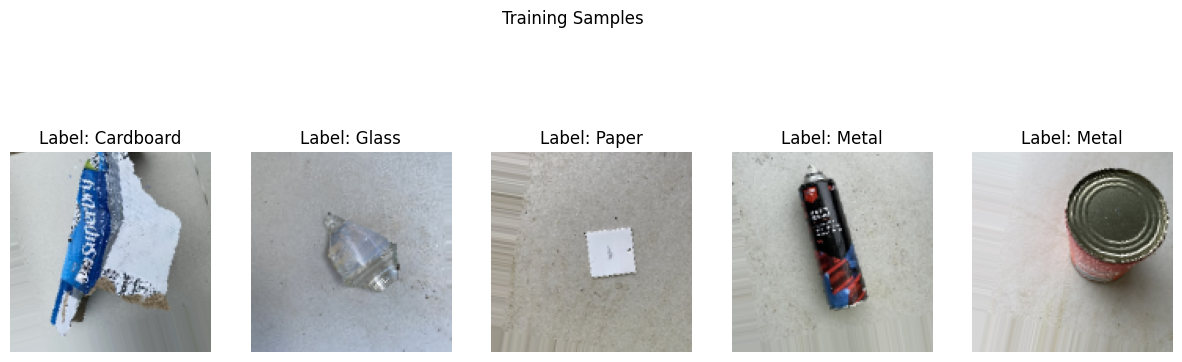

In [5]:
# Data generators
datagen = ImageDataGenerator(
    rescale=1.0 / 255, 
    rotation_range=15, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32, class_mode='sparse'
)

val_data = datagen.flow_from_directory(
    val_dir, target_size=(128, 128), batch_size=32, class_mode='sparse'
)

test_data = datagen.flow_from_directory(
    test_dir, target_size=(128, 128), batch_size=32, class_mode='sparse', shuffle=False
)

# Class names
class_names = list(train_data.class_indices.keys())

# Plot samples
def plot_samples(data_gen, class_names, num_samples=5):
    images, labels = next(data_gen)
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {class_names[int(labels[i])]}") 
        plt.axis('off')

plot_samples(train_data, class_names, num_samples=5)
plt.suptitle('Training Samples')
plt.show()

### 3.Model Architecture

In [6]:
# Define the CNN model
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

C:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,519,241 (24.87 MB)

 Trainable params: 6,518,793 (24.87 MB)

 Non-trainable params: 448 (1.75 KB)

### 4.Train the model

In [7]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20
)

C:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 88s 955ms/step - accuracy: 0.2757 - loss: 4.8467 - val_accuracy: 0.0884 - val_loss: 17.0620
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 78s 873ms/step - accuracy: 0.3279 - loss: 1.8916 - val_accuracy: 0.0884 - val_loss: 20.7220
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 75s 842ms/step - accuracy: 0.3427 - loss: 1.8716 - val_accuracy: 0.0905 - val_loss: 10.4975
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 70s 792ms/step - accuracy: 0.3286 - loss: 1.8229 - val_accuracy: 0.1874 - val_loss: 4.8333
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 85s 952ms/step - accuracy: 0.4114 - loss: 1.7128 - val_accuracy: 0.1695 - val_loss: 4.7044
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 79s 883ms/step - accuracy: 0.4034 - loss: 1.7602 - val_accuracy: 0.2221 - val_loss: 4.8266
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 74s 836ms/step - accuracy: 0.4280 - loss: 1.5902 - val_accuracy: 0.2463 - val_loss: 1.9941
Epoch 8/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 76s 848ms/step - accuracy: 0.4180 - loss: 1.6046 - val_a

### 5.Evaluate the Model 

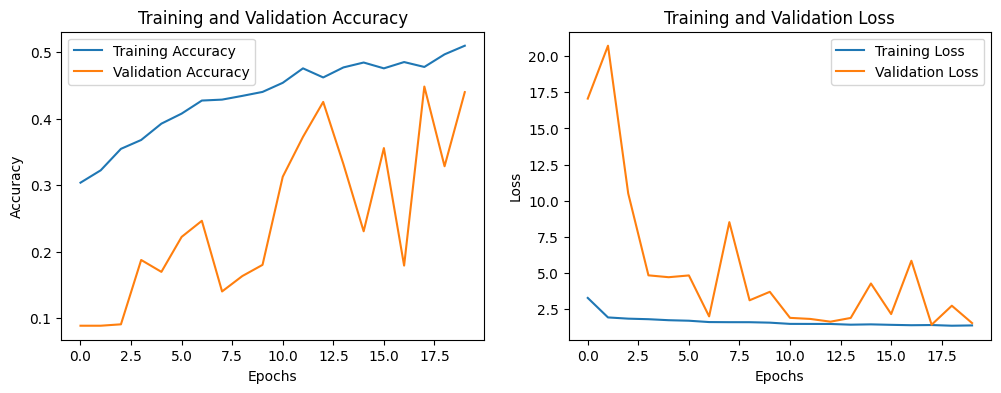

In [10]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

plot_history(history)

In [11]:
# Evaluate model
print("\n--- Evaluation ---")
train_loss, train_acc = model.evaluate(train_data)
val_loss, val_acc = model.evaluate(val_data)
test_loss, test_acc = model.evaluate(test_data)

print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")


--- Evaluation ---
89/89 ━━━━━━━━━━━━━━━━━━━━ 22s 251ms/step - accuracy: 0.4898 - loss: 1.4239
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.4729 - loss: 1.4801
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 337ms/step - accuracy: 0.3797 - loss: 1.6454
Training Loss: 1.4310, Accuracy: 0.4863
Validation Loss: 1.5266, Accuracy: 0.4568
Test Loss: 1.5053, Accuracy: 0.4560


30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step


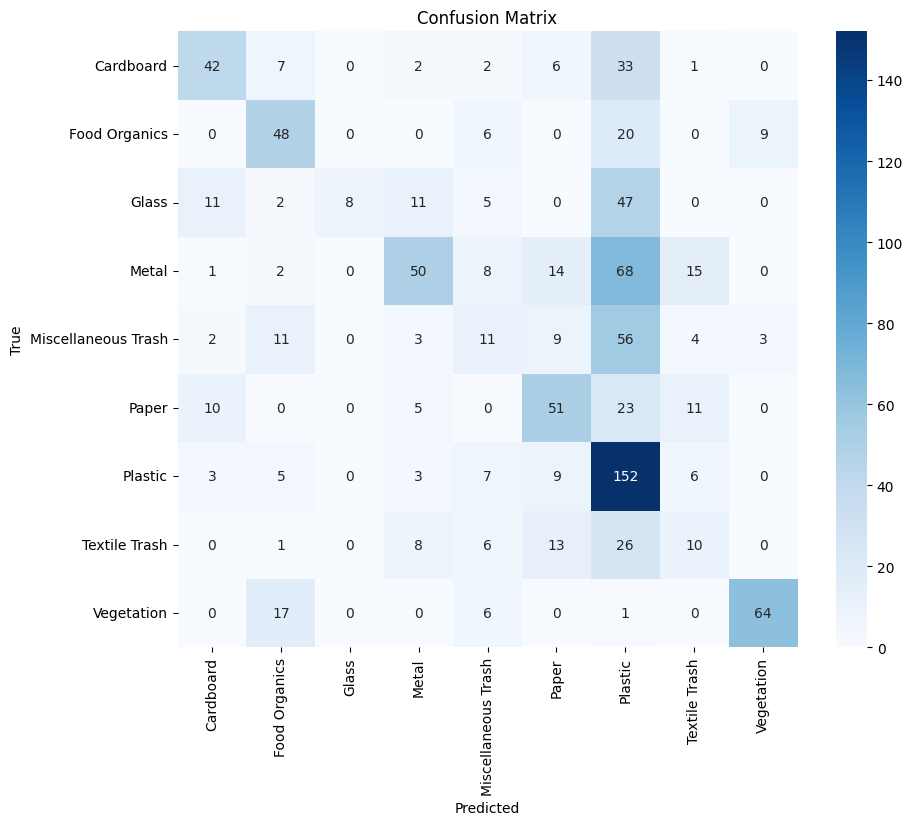


--- Classification Report ---
                     precision    recall  f1-score   support

          Cardboard       0.61      0.45      0.52        93
      Food Organics       0.52      0.58      0.55        83
              Glass       1.00      0.10      0.17        84
              Metal       0.61      0.32      0.42       158
Miscellaneous Trash       0.22      0.11      0.15        99
              Paper       0.50      0.51      0.50       100
            Plastic       0.36      0.82      0.50       185
      Textile Trash       0.21      0.16      0.18        64
         Vegetation       0.84      0.73      0.78        88

           accuracy                           0.46       954
          macro avg       0.54      0.42      0.42       954
       weighted avg       0.53      0.46      0.43       954



In [12]:
#Generate predictions
y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))

Training with learning rate: 0.0001

Training with learning rate: 0.001

Training with learning rate: 0.01

Training with learning rate: 0.1



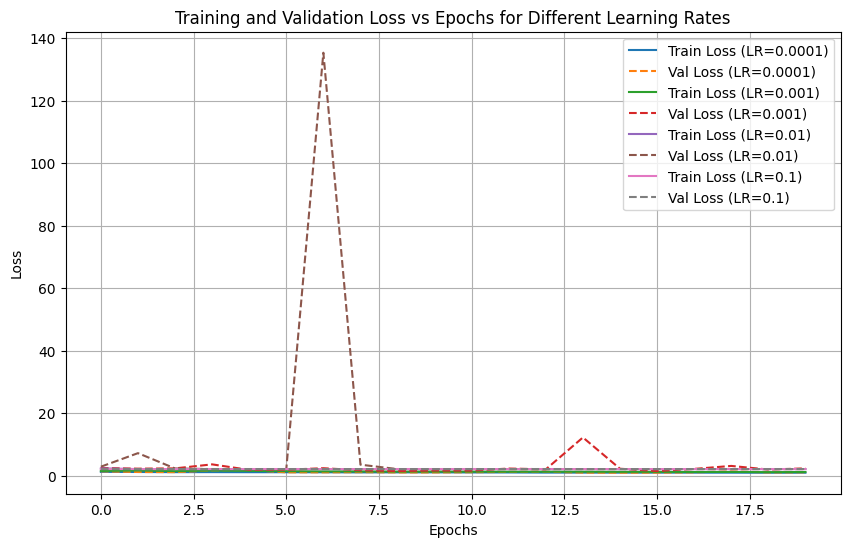

In [14]:
# Learning rates to test
learning_rates = [0.0001, 0.001, 0.01, 0.1]
history_dict = {}  # To store training history for each learning rate

# Loop over each learning rate and train the model
for lr in learning_rates:
    print(f"Training with learning rate: {lr}\n")
    
    # Compile the model with the current learning rate
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train the model
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=20,
        verbose=0  # Suppress verbose output
    )
    
    # Store the history
    history_dict[lr] = history.history

# Plot training and validation loss for each learning rate
plt.figure(figsize=(10, 6))

for lr, hist in history_dict.items():
    plt.plot(hist['loss'], label=f'Train Loss (LR={lr})')
    plt.plot(hist['val_loss'], linestyle='--', label=f'Val Loss (LR={lr})')

plt.title('Training and Validation Loss vs Epochs for Different Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()